In [2]:
!pip install imageio

import os
import cv2
import time
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import sys
import imageio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [2]:
# Check GPU Configuration and Set Memory Growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Device: {gpu}")
else:
    print("No GPU found. TensorFlow is using the CPU.")

Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Device: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [3]:
import pandas as pd
import os

# Define paths
BASE_PATH = "../input/car-crash-dataset-ccd/CrashBest/"
TABLENAME = "../input/car-crash-dataset-ccd/Crash_Table.csv"

# Read the CSV file
df = pd.read_csv(TABLENAME)

print(df.head())

   vidname  frame_1  frame_2  frame_3  frame_4  frame_5  frame_6  frame_7  \
0        1        0        0        0        0        0        0        0   
1        2        0        0        0        0        0        0        0   
2        3        0        0        0        0        0        0        0   
3        4        0        0        0        0        0        0        0   
4        5        0        0        0        0        0        0        0   

   frame_8  frame_9  ...  frame_46  frame_47  frame_48  frame_49  frame_50  \
0        0        0  ...         1         1         1         1         1   
1        0        0  ...         1         1         1         1         1   
2        0        0  ...         1         1         1         1         1   
3        0        0  ...         1         1         1         1         1   
4        0        0  ...         1         1         1         1         1   

   startframe  youtubeID  timing  weather  egoinvolve  
0         28

In [4]:
print(df.columns)

Index(['vidname', 'frame_1', 'frame_2', 'frame_3', 'frame_4', 'frame_5',
       'frame_6', 'frame_7', 'frame_8', 'frame_9', 'frame_10', 'frame_11',
       'frame_12', 'frame_13', 'frame_14', 'frame_15', 'frame_16', 'frame_17',
       'frame_18', 'frame_19', 'frame_20', 'frame_21', 'frame_22', 'frame_23',
       'frame_24', 'frame_25', 'frame_26', 'frame_27', 'frame_28', 'frame_29',
       'frame_30', 'frame_31', 'frame_32', 'frame_33', 'frame_34', 'frame_35',
       'frame_36', 'frame_37', 'frame_38', 'frame_39', 'frame_40', 'frame_41',
       'frame_42', 'frame_43', 'frame_44', 'frame_45', 'frame_46', 'frame_47',
       'frame_48', 'frame_49', 'frame_50', 'startframe', 'youtubeID', 'timing',
       'weather', 'egoinvolve'],
      dtype='object')


# MANUAL PRE-PROCESSING AND LABELLING

In [4]:
def generate_frame_paths(video_name):
    frame_paths = []
    for i in range(1, 51):  
        frame_number = str(i).zfill(2)  # Ensure two digits with leading zeros
        file_name = f"C_{video_name:06}_{frame_number}.jpg"  # Six-digit video name
        frame_path = os.path.join(BASE_PATH, file_name)
        frame_paths.append(frame_path)
    return frame_paths

# Create lists to store image paths and labels
image_paths = []
labels = []

half_rows = len(df) //3  # Calculate  total number of rows // 2 to divide dataset 
print(half_rows)

# Iterate through the first half of the rows in the CSV
for index, row in df.head(half_rows).iterrows():
    # Generate frame paths for the current video
    frame_paths = generate_frame_paths(row['vidname']) 
#     print("Generated frame paths:", frame_paths)  #
    # Check if all frame paths exist
    if all(os.path.exists(path) for path in frame_paths):
        # Add frame paths and labels to the lists
        image_paths.extend(frame_paths)
        labels.extend(row[f"frame_{i}"] for i in range(1, 51))

# # Iterate through each row in the CSV
# for index, row in df.iterrows():

# Check the number of valid image paths and labels
print(f"Number of valid image paths: {len(image_paths)}")
print(f"Number of valid labels: {len(labels)}")

500
Number of valid image paths: 25000
Number of valid labels: 25000


# Pre-Processing for ViT

In [5]:
print("Length of image_paths:", len(image_paths))
print("Length of labels:", len(labels))

# Print a few sample image paths and labels to investigate
for i in range(5):
    print("Sample", i+1, ": Image Path:", image_paths[i], "Label:", labels[i])

Length of image_paths: 25000
Length of labels: 25000
Sample 1 : Image Path: ../input/car-crash-dataset-ccd/CrashBest/C_000001_01.jpg Label: 0
Sample 2 : Image Path: ../input/car-crash-dataset-ccd/CrashBest/C_000001_02.jpg Label: 0
Sample 3 : Image Path: ../input/car-crash-dataset-ccd/CrashBest/C_000001_03.jpg Label: 0
Sample 4 : Image Path: ../input/car-crash-dataset-ccd/CrashBest/C_000001_04.jpg Label: 0
Sample 5 : Image Path: ../input/car-crash-dataset-ccd/CrashBest/C_000001_05.jpg Label: 0


In [6]:
from datasets import Dataset

# Create a dictionary containing the image paths and labels
data_dict = {"image": image_paths, "label": labels}

# Create a dataset from the dictionary
custom_dataset = Dataset.from_dict(data_dict)

# Print the number of samples in the dataset
print("Number of samples in the dataset:", len(custom_dataset))

# Print the first few samples in the dataset
print("First few samples in the dataset:")
print(custom_dataset[:5])

Number of samples in the dataset: 25000
First few samples in the dataset:
{'image': ['../input/car-crash-dataset-ccd/CrashBest/C_000001_01.jpg', '../input/car-crash-dataset-ccd/CrashBest/C_000001_02.jpg', '../input/car-crash-dataset-ccd/CrashBest/C_000001_03.jpg', '../input/car-crash-dataset-ccd/CrashBest/C_000001_04.jpg', '../input/car-crash-dataset-ccd/CrashBest/C_000001_05.jpg'], 'label': [0, 0, 0, 0, 0]}


In [7]:
# Define the ratio for splitting the dataset
train_ratio = 0.8  # 80% for training, 20% for testing

# Calculate the number of samples for training and testing
num_train_samples = int(len(custom_dataset) * train_ratio)
num_test_samples = len(custom_dataset) - num_train_samples

# Split the dataset into training and testing sets
train_dataset = custom_dataset.select(range(num_train_samples))
test_dataset = custom_dataset.select(range(num_train_samples, num_train_samples + num_test_samples))

# Print the number of samples in the training and testing datasets
print("Number of samples in the training dataset:", len(train_dataset))
print("Number of samples in the testing dataset:", len(test_dataset))

Number of samples in the training dataset: 20000
Number of samples in the testing dataset: 5000


In [8]:
def check_dataset_type(dataset):
    print("Dataset type:", type(dataset))

# Call the function to check the type of test_dataset
check_dataset_type(test_dataset)

Dataset type: <class 'datasets.arrow_dataset.Dataset'>


# Pre-Processing for MobileNet and MobileLSTM

In [18]:
import tensorflow as tf
from numba import cuda

# Configure TensorFlow to limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

def load_and_preprocess_image(file_path):
    # Read the image file without fully loading it into memory
    image = tf.io.read_file(file_path)
    # Decode the image and resize it while conserving memory
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256,256])
    # Convert image to float32 and normalize
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

# Test the function with one image path
print(load_and_preprocess_image(image_paths[0]).shape)

2 Physical GPUs, 2 Logical GPUs
(256, 256, 3)


In [19]:
# Create a dataset from the image paths
image_paths_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
labels_dataset = tf.data.Dataset.from_tensor_slices(labels)

# Map the load_and_preprocess_image function to load and preprocess each image
image_dataset = image_paths_dataset.map(load_and_preprocess_image)

# Zip the image and label datasets together
dataset = tf.data.Dataset.zip((image_dataset, labels_dataset))

dataset = dataset.batch(128)

# Test the function with one batch
for images, labels in dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

Images shape: (128, 256, 256, 3)
Labels shape: (128,)


# To run ConvLSTM

In [14]:
time_steps = 50
# Expand the tensor along the new timestep dimension
timestep_dataset = dataset.map(lambda images, labels: (tf.tile(tf.expand_dims(images, axis=1), [1, time_steps, 1, 1, 1]), labels))

# Test the function with one batch
for images, labels in timestep_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

Images shape: (128, 50, 256, 256, 3)
Labels shape: (128,)


File Path: ../input/car-crash-dataset-ccd/CrashBest//C_000009_29.jpg


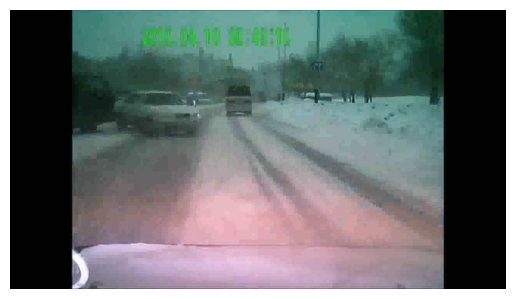

In [9]:
import cv2
import matplotlib.pyplot as plt

FILENAME = "/C_000009_"
FRAME = "29"
SCALE = 4

# Define the file path
file_path = BASE_PATH + FILENAME + FRAME + ".jpg"
print("File Path:", file_path)

# Read the image
img = cv2.imread(file_path)

# Display the image using Matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.axis('off')  # Hide axis
plt.show()

In [20]:
import tensorflow as tf

#WITHOUT TIMESTEP
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# #WITH TIMESTEP
# timestep_dataset_size = len(timestep_dataset)
# train_size = int(timestep_dataset_size * 0.8)
# train_timestep_dataset = timestep_dataset.take(train_size)
# test_timestep_dataset = timestep_dataset.skip(train_size)

print(train_size)

468


# SIMPLE MOBILENET MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def MobileNetV2(input_shape=(256, 256, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)
    
    # MobileNetV2 backbone
    backbone = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')(inputs)
    
    # Add custom head for classification
    x = layers.GlobalAveragePooling2D()(backbone)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x) 
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='MobileNetV2')
    return model


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Example usage
model = MobileNetV2()
model.summary()

In [ ]:
import time 
model.compile(optimizer='adam', loss="binary_crossentropy", metrics = ['binary_accuracy'])

# Start measuring time
start_time = time.time()

history=model.fit(train_dataset, epochs=12, verbose=1, validation_data=test_dataset)

# Calculate the time taken for training
end_time = time.time()
training_time = end_time - start_time

print("Time taken to train the neural network: {:.2f} seconds".format(training_time))

Epoch 1/12


2024-05-30 10:01:38.348903: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[128,96,129,129]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,96,131,131]{3,2,1,0}, f32[96,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-30 10:01:39.952450: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.603665284s
Trying algorithm eng3{k11=2} for conv (f32[128,96,129,129]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,96,131,131]{3,2,1,0}, f32[96,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-30 10:01:

468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - binary_accuracy: 0.7570 - loss: 0.5015

W0000 00:00:1717063688.002107     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


468/468 ━━━━━━━━━━━━━━━━━━━━ 517s 878ms/step - binary_accuracy: 0.7571 - loss: 0.5014 - val_binary_accuracy: 0.7301 - val_loss: 1.3543
Epoch 2/12


W0000 00:00:1717063758.970221     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


468/468 ━━━━━━━━━━━━━━━━━━━━ 365s 780ms/step - binary_accuracy: 0.7918 - loss: 0.4267 - val_binary_accuracy: 0.7071 - val_loss: 0.7381
Epoch 3/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 373s 796ms/step - binary_accuracy: 0.8049 - loss: 0.4061 - val_binary_accuracy: 0.5568 - val_loss: 0.8792
Epoch 4/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 365s 780ms/step - binary_accuracy: 0.8128 - loss: 0.3873 - val_binary_accuracy: 0.5130 - val_loss: 1.2619
Epoch 5/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 363s 776ms/step - binary_accuracy: 0.8282 - loss: 0.3626 - val_binary_accuracy: 0.3084 - val_loss: 3.8542
Epoch 6/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 370s 791ms/step - binary_accuracy: 0.8392 - loss: 0.3458 - val_binary_accuracy: 0.4713 - val_loss: 1.5207
Epoch 7/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 363s 776ms/step - binary_accuracy: 0.8614 - loss: 0.3169 - val_binary_accuracy: 0.2811 - val_loss: 4.4179
Epoch 8/12
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - binary_accuracy: 0.8745 - loss: 0.2839

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming you have the history object from training the model
# Replace history with your actual variable name containing the history object
plot_accuracy(history)
plot_loss(history)

# MOBILENET+LSTM MODEL

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, Model

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

def MobileNetV2_LSTM(input_shape=(64,64, 3), time_steps=50, num_classes=1):  # Reduced input size 
    inputs = tf.keras.Input(shape=(time_steps,) + input_shape)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', alpha=0.5) 
    base_model.trainable = False  # Freeze MobileNetV2 layers
    for layer in base_model.layers[-20:]:  # Unfreeze last 20 layer
        layer.trainable = True
    
    def apply_mobilenet(frame):
        frame_features = base_model(frame)
        return frame_features

    # Apply TimeDistributed to the wrapped model
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Lambda(apply_mobilenet))(inputs)
    
    # Reshape the tensor for LSTM input
    x = tf.keras.layers.Reshape((time_steps, -1))(x)  # Reshape to (time_steps, features)
    
    x = tf.keras.layers.LSTM(64, return_sequences=False)(x)
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)  
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid', dtype='float32')(x)  # Ensure output is float32
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MobileNetV2_LSTM')
    
    # Print the dimensions of the input layer
    input_shape = model.input_shape[1:]
    print("Dimensions of Input Layer 0:", input_shape)  
    
    return model

In [27]:
# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
    # Instantiate the model with updated parameters
input_shape = (64, 64, 3)
time_steps = 50
batch_size = None
model = MobileNetV2_LSTM(input_shape=input_shape, time_steps=time_steps)
model.summary()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Create the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with the custom optimizer
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['binary_accuracy'])

# model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['binary_accuracy'])

/tmp/ipykernel_34/642158565.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', alpha=0.5)


3201480/3201480 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dimensions of Input Layer 0: (50, 64, 64, 3)


Model: "MobileNetV2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 50, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 50, 2, 2, 1280) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 50, 5120)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │     1,327,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,335,809 (5.10 MB)

 Trainable params: 1,335,809 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
import time

# Start measuring time
start_time = time.time()

# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
history=model.fit(train_timestep_dataset, epochs=12, verbose=1, validation_data=test_timestep_dataset)

# Calculate the time taken for training
end_time = time.time()
training_time = end_time - start_time

print("Time taken to train the neural network: {:.2f} seconds".format(training_time))

Epoch 1/12
78/78 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - binary_accuracy: 0.7005 - loss: 1.2800 - val_binary_accuracy: 0.7673 - val_loss: 0.8068
Epoch 2/12
78/78 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - binary_accuracy: 0.7216 - loss: 0.7712 - val_binary_accuracy: 0.7673 - val_loss: 0.6284
Epoch 3/12
78/78 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - binary_accuracy: 0.7247 - loss: 0.6056 - val_binary_accuracy: 0.7671 - val_loss: 0.5806
Epoch 4/12
78/78 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - binary_accuracy: 0.7479 - loss: 0.5322 - val_binary_accuracy: 0.7548 - val_loss: 0.5818
Epoch 5/12
78/78 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - binary_accuracy: 0.7873 - loss: 0.4752 - val_binary_accuracy: 0.7222 - val_loss: 0.6029
Epoch 6/12
78/78 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - binary_accuracy: 0.8190 - loss: 0.4239 - val_binary_accuracy: 0.7063 - val_loss: 0.6406
Epoch 7/12
78/78 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - binary_accuracy: 0.8508 - loss: 0.3775 - val_binary_accuracy: 0.6938 - val_loss: 0.7058
Epoch 8/12
78

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming you have the history object from training the model
# Replace history with your actual variable name containing the history object
plot_accuracy(history)
plot_loss(history)

# Vision Transformer Model

In [9]:
from transformers import (  
    TrainingArguments,  
    Trainer,  
    ViTImageProcessor, 
    ViTForImageClassification, 
    DefaultDataCollator 
)
import torch  
from torch.utils.data import DataLoader  
from torchvision.transforms import (  
    CenterCrop,  
    Compose,  
    Normalize,  
    RandomRotation,  
    RandomResizedCrop,  
    RandomHorizontalFlip,  
    RandomAdjustSharpness, 
    Resize,  
    ToTensor 
)

In [10]:
model_str = 'google/vit-base-patch16-224-in21k'

processor = ViTImageProcessor.from_pretrained(model_str)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [11]:
image_mean, image_std = processor.image_mean, processor.image_std

In [12]:

from PIL import Image

size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        Resize((size, size)),             
        RandomRotation(30),               
        RandomAdjustSharpness(2),         
        ToTensor(),                       
        normalize                         
    ]
)

_val_transforms = Compose(
    [
        Resize((size, size)),             
        ToTensor(),                       
        normalize                        
    ]
)

from PIL import Image
import matplotlib.pyplot as plt

# Define the train_transforms function
def train_transforms(example):
    # Load images from file paths
    images = [Image.open(image_path).convert("RGB") for image_path in example['image']]
    # Apply transformations to each image
    transformed_images = [_train_transforms(image) for image in images]
    # Replace the 'image' column with the transformed images
    example['pixel_values'] = transformed_images    
    return example

# Define the val_transforms function
def val_transforms(example):
    if 'image' not in example:
        print("transforms called")
    else:
        images = [Image.open(image_path).convert("RGB") for image_path in example['image']]
        transformed_images = [_val_transforms(image) for image in images]
        example['pixel_values'] = transformed_images
    return example

Size:  224


In [13]:
# Debugging: Check the dataset before and after transformations
print("Before setting transforms:")
print(train_dataset[0])
print(test_dataset[0])

train_dataset.set_transform(train_transforms)
test_dataset.set_transform(val_transforms)

print("After setting transforms:")
print(train_dataset[0])
print(test_dataset[0])

Before setting transforms:
{'image': '../input/car-crash-dataset-ccd/CrashBest/C_000001_01.jpg', 'label': 0}
{'image': '../input/car-crash-dataset-ccd/CrashBest/C_000401_01.jpg', 'label': 0}
After setting transforms:
{'image': '../input/car-crash-dataset-ccd/CrashBest/C_000001_01.jpg', 'label': 0, 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -

In [14]:
def collate_fn(examples):
    
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    
    labels = torch.tensor([example['label'] for example in examples])
    
    return {"pixel_values": pixel_values, "labels": labels}

In [15]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=2, device_map='sequential')

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor
from transformers import Trainer, TrainingArguments
from PIL import Image

feature_extractor = ViTImageProcessor.from_pretrained(model_str)


# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',  # Batch size per GPU
    num_train_epochs=4,              # Number of training epochs
    logging_dir='./logs',     
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=16,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
)

# Define a function to preprocess the dataset
def preprocess_function(examples):
    images = [Image.open(image_path).convert("RGB") for image_path in examples['image']]
    
    images = [feature_extractor(image, return_tensors="pt")['pixel_values'] for image in images]
    
    # Convert labels to tensor
    labels = torch.tensor(examples['label'])
    
    return {'pixel_values': torch.stack(images, dim=0), 'labels': labels}

# Preprocess the training dataset
train_dataset = train_dataset.map(preprocess_function, batched=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    data_collator=collate_fn,
)

# Train the model
trainer.train()
#add wandb password

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,No log,0.483403
2,No log,0.465459
3,No log,0.463996
4,0.449100,0.469111


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=628, training_loss=0.4246867234539834, metrics={'train_runtime': 12103.4623, 'train_samples_per_second': 6.61, 'train_steps_per_second': 0.052, 'total_flos': 6.19935916916736e+18, 'train_loss': 0.4246867234539834, 'epoch': 4.0})

In [17]:
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['image', 'label', 'pixel_values', 'labels'],
    num_rows: 20000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})


In [18]:
from sklearn.metrics import accuracy_score

# Generate predictions

predictions = trainer.predict(test_dataset)

# Extract predicted labels
predicted_labels = predictions.predictions.argmax(axis=1)

# Extract ground truth labels
true_labels = test_dataset['label']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


transforms called
Accuracy: 0.7892
